In [93]:
import torch
import torch.nn as nn
import os

from image_embedding_models import *

data_dir = '/raid/hlcv19/team22/imet/data/'
model = torch.load(os.path.join(data_dir, 'resnet18_embeddings_trainable_resnet_2.0'))

In [94]:
import pandas as pd
from skimage import io
import numpy as np
import random

annotations_path = os.path.join(data_dir, 'train_.csv')
annotations_frame = pd.read_csv(annotations_path)
idx=random.randint(0,1103)
img_name = annotations_frame.iloc[idx, 0]
path = os.path.join(data_dir, "train", img_name) + '.png'
image = io.imread(path)
image = np.asarray(image)

In [95]:
import torchvision
from torchvision import transforms

data_transforms = transforms.Compose([
    torchvision.transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

_, out = model(data_transforms(image).cuda().unsqueeze(0))
out

tensor([[-0.0581,  0.0064, -0.1356, -0.1466, -0.1580,  0.0090, -0.0136, -0.1373,
          0.0238,  0.0413,  0.0838,  0.0574,  0.0118, -0.0497,  0.0287, -0.1016,
          0.1534, -0.0485,  0.1038, -0.0362,  0.1623,  0.1382,  0.1042,  0.0680,
         -0.1058,  0.1345, -0.0553, -0.1266, -0.1963, -0.0425, -0.1719,  0.0229,
          0.0807,  0.0941,  0.0603,  0.0738, -0.0465,  0.0783,  0.0102,  0.0217,
         -0.0544,  0.0313, -0.1059, -0.1340,  0.1177, -0.1943, -0.1214,  0.0459,
          0.1472, -0.0149,  0.0459, -0.0166,  0.1633,  0.1926,  0.1013,  0.0841,
         -0.0251, -0.0198, -0.1077, -0.0885,  0.0256,  0.0397,  0.1185,  0.0131,
          0.0118, -0.0075,  0.0818, -0.0835, -0.1149, -0.0285, -0.0691, -0.1179,
         -0.0159, -0.2590,  0.1580, -0.1344, -0.1454, -0.0438, -0.2010,  0.0895,
          0.0749,  0.1483, -0.1818, -0.0253,  0.0255,  0.0895,  0.1023,  0.0402,
         -0.0669, -0.0745,  0.0418, -0.0123, -0.1493,  0.0882, -0.1213, -0.0972,
         -0.0276,  0.0916, -

In [96]:

from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
class LabelEmbeddings:
    def __init__(self, labels_path, annotations_path, load_path=""):  
        self.labels_to_ix = {}
        self.ix_to_label = {}

        with open(labels_path) as labels_f:
            lines = labels_f.readlines()
            for l in lines[1:]:
                idx, label = l.strip().split(',')
                self.labels_to_ix[label] = int(idx)
                self.ix_to_label[int(idx)] = label

        self.vocab = list(self.labels_to_ix.keys())
        vocab_size = len(self.vocab)

        words_context = [] 
        with open(annotations_path) as labels_f:
            lines = labels_f.readlines()
            for line in lines[1:]:
                labels = line.strip().split(',')[1].split()
                labels = [int(l) for l in labels]
                for i in range(len(labels)):
                    for j in range(i+1, len(labels)):
                        words_context.append((self.ix_to_label[labels[i]], self.ix_to_label[labels[j]]))

        if load_path == "":
            self.label_embeddings = Word2Vec(min_count=1, size=10)
            self.label_embeddings.build_vocab(words_context)  # prepare the model vocabulary
            self.label_embeddings.train(words_context, total_examples=self.label_embeddings.corpus_count, 
                                        epochs=self.label_embeddings.iter)  # train word vectors
        else:
            self.label_embeddings = Word2Vec.load(load_path)
    
    def __getitem__(self, idx):
        return self.label_embeddings.wv[self.ix_to_label[idx]]
    
    def dim(self):
        return len(self.label_embeddings.wv[self.vocab[0]])
    
    def most_similar(self, label):
        return self.label_embeddings.most_similar(positive=label)
    
    def save(self, path):
        self.label_embeddings.save(path)


In [97]:
labels_path = os.path.join(data_dir, 'labels.csv')
label_embeddings = LabelEmbeddings(labels_path, annotations_path)#, load_path=os.path.join(data_dir, 'label2v.model'))
#label_embeddings.save()
label_embeddings.label_embeddings.wv.init_sims()

/raid/hlcv19/team22/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


In [98]:
label_embeddings.most_similar("tag::jesus")

/raid/hlcv19/team22/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).


[('tag::christian imagery', 0.9923927783966064),
 ('tag::christianity', 0.9849667549133301),
 ('tag::last supper', 0.9801656007766724),
 ('tag::christ', 0.9793559312820435),
 ('tag::saints', 0.9786850214004517),
 ('tag::virgin mary', 0.9783992767333984),
 ('tag::mary magdalene', 0.9767321348190308),
 ('tag::saint john the baptist', 0.9719750285148621),
 ('tag::saint anne', 0.9698808193206787),
 ('tag::nativity', 0.9667806625366211)]

In [99]:
print(annotations_frame.iloc[idx, 0])

10f4bcba31d25569


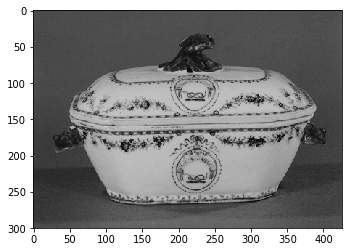

10f4bcba31d25569
culture::for british market
tag::utilitarian objects
culture::turkish or venice


In [100]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.show()
print(annotations_frame.iloc[idx, 0])
for li in annotations_frame.iloc[idx, 1].split():
    print(label_embeddings.ix_to_label[int(li)])


In [101]:
labels_distances = []
for word in label_embeddings.vocab:
    lv = torch.tensor(label_embeddings.label_embeddings.wv.word_vec(word, use_norm=True), device="cuda").unsqueeze(0)
    dist = torch.nn.functional.cosine_similarity(out, lv)
    labels_distances.append((word, dist.item()))
    
sorted(labels_distances, key=lambda x:x[1], reverse=True)

RuntimeError: The size of tensor a (100) must match the size of tensor b (10) at non-singleton dimension 1

In [ ]:
from numpy import linalg as LA
min_emb = 10000
max_emb = -10000
label_embeddings.label_embeddings.wv.init_sims()
for word in label_embeddings.vocab:
    max_emb = max(max_emb, np.max(label_embeddings.label_embeddings.wv.word_vec(word, use_norm=True)))
    min_emb = min(min_emb, np.min(label_embeddings.label_embeddings.wv.word_vec(word, use_norm=True)))
    
print(min_emb, max_emb)

In [ ]:
labels = np.zeros((2, 20))
label_idxs = [[3, 4, 7], [1, 3, 5]]
labels[0][label_idxs[0]] = 1
labels[1][label_idxs[1]] = 1
labels = torch.ByteTensor(labels)
torch.nonzero(labels)

In [ ]:
torch.tensor([1, 2, 3])